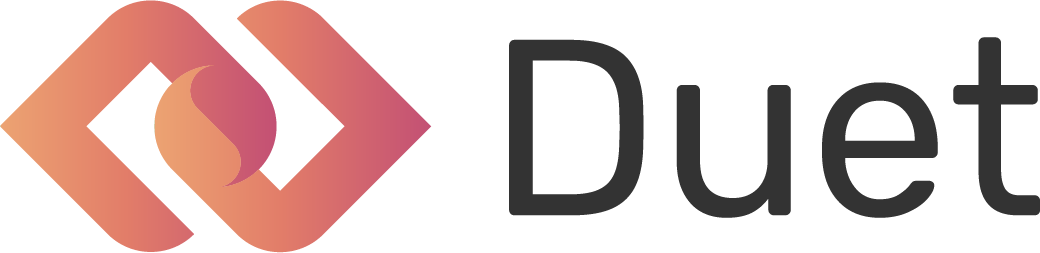

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.join_duet(loopback=True)

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!

RECOMPILINGLIVE STATUS  *  Objects: 0  Requests: 0   Messages: 1  Request Handlers: 1                                
RECOMPILING
RECOMPILINGLIVE STATUS  *  Objects: 0  Requests: 0   Messages: 1  Request Handlers: 1                                
RECOMPILING
RECOMPILINGLIVE STATUS  *  Objects: 0  Requests: 0   Messages: 1  Request Handlers: 1                                
RECOMPILING
RECOMPILINGL

In [1]:
import syft as sy
duet = sy.launch_duet(loopback=True)
sy.logger.add(sink="./syft_do.log")

In [2]:
# stdlib
import re
from typing import Any
from typing import List as TypeList

import torch
from torchvision import transforms

from original.neural_style import utils

from syft import SyModule
from syft import SySequential
from syft import logger
from syft.core.plan.plan_builder import ROOT_CLIENT
from syft.core.plan.plan_builder import make_plan
# from original.neural_style.vgg import Vgg16
# from original.neural_style.transformer_net import TransformerNet # redefined below

In [3]:
# handler with no tags accepts everything. Better handlers coming soon.
duet.requests.add_handler(action="accept")

In [4]:
args = {"image_size":None,
        "dataset":None,
        "batch_size":4,
        "cuda":False}

In [5]:
class TransformerNet(SyModule):
    def __init__(self, **kwargs: Any) -> None:
        super().__init__(**kwargs)
        # Initial convolution layers
        self.conv1 = ConvLayer(in_channels = 3, 
                               out_channels = 32, 
                               kernel_size=9, stride=1,
                               input_size=(1, 3, 1080, 1080))
        self.in1 = torch.nn.InstanceNorm2d(num_features=32,
                                           affine=True)
        self.conv2 = ConvLayer(in_channels = 32,
                               out_channels = 64,
                               kernel_size=3, stride=2,
                               input_size=(1, 32, 1080, 1080))
        self.in2 = torch.nn.InstanceNorm2d(num_features=64,
                                           affine=True)
        self.conv3 = ConvLayer(in_channels = 64,
                               out_channels = 128, kernel_size=3,
                               stride=2,
                               input_size=(1, 64, 540, 540))
        self.in3 = torch.nn.InstanceNorm2d(num_features=128,
                                           affine=True)
        # Residual layers
        self.res1 = ResidualBlock(input_size=(1, 128, 270, 270))
        self.res2 = ResidualBlock(input_size=(1, 128, 270, 270))
        self.res3 = ResidualBlock(input_size=(1, 128, 270, 270))
        self.res4 = ResidualBlock(input_size=(1, 128, 270, 270))
        self.res5 = ResidualBlock(input_size=(1, 128, 270, 270))
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(in_channels=128, 
                                         out_channels=64,
                                         kernel_size=3,
                                         stride=1,
                                         #upsample=2,
                                         input_size=(1, 128, 270, 270))
        self.in4 = torch.nn.InstanceNorm2d(num_features=64, affine=True)
        self.deconv2 = UpsampleConvLayer(in_channels=64,
                                         out_channels=32,
                                         kernel_size=3,
                                         stride=1,
                                         #upsample=2,
                                         input_size=(1, 64, 540, 540))
        self.in5 = torch.nn.InstanceNorm2d(num_features=32, affine=True)
        self.deconv3 = ConvLayer(in_channels=32,
                                 out_channels=3,
                                 kernel_size=9, stride=1,
                                 input_size=(1, 32, 1080, 1080))
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x=x)[0]))
        y = self.relu(self.in2(self.conv2(x=y)[0]))
        y = self.relu(self.in3(self.conv3(x=y)[0]))
        
        y = self.res1(x=y)[0]
        y = self.res2(x=y)[0]
        y = self.res3(x=y)[0]
        y = self.res4(x=y)[0]
        y = self.res5(x=y)[0]
        
        y = self.relu(self.in4(self.deconv1(x=y)[0]))
        y = self.relu(self.in5(self.deconv2(x=y)[0]))
        y = self.deconv3(x=y)[0]
        return y
    
class ConvLayer(SyModule):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 **kwargs: Any) -> None:
        super().__init__(**kwargs)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(padding=reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(SyModule):
    def __init__(self, **kwargs: Any) -> None:
        super().__init__(**kwargs)
        channels = 128
        self.conv1 = ConvLayer(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               stride=1,
                               input_size=(1, 128, 270, 270))
        self.in1 = torch.nn.InstanceNorm2d(num_features=channels, affine=True)
        self.conv2 = ConvLayer(in_channels=128,
                               out_channels=128,
                               kernel_size=3, stride=1,
                               input_size=(1, 128, 270, 270))
        self.in2 = torch.nn.InstanceNorm2d(num_features=channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x=x)[0]))
        out = self.in2(self.conv2(x=out)[0])
        out = out + residual
        return out


class UpsampleConvLayer(SyModule):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 upsample: float=None,
                 **kwargs: Any) -> None:
        super().__init__(**kwargs)
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(padding=reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = remote_torch.nn.functional.interpolate(
                x_in, mode="nearest", scale_factor=self.upsample
            )
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [6]:
remote_torch = duet.torch
remote_python = duet.python
remote_torchvision = duet.torchvision

In [7]:
content_image = utils.load_image("original/images/content_images/amber.jpg")
content_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.mul(255))]
)

content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0)

In [8]:
transformnet = TransformerNet(input_size=(1, 3, 1080, 1080))
dummy_dl = sy.lib.python.List([content_image])

[2021-05-11T10:59:38.880018+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb298a7f49074f85bb0ed3ff852d15da>.
[2021-05-11T11:02:42.395062+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b20a78813cc545da9cc238ba3c532713>.
[2021-05-11T11:04:04.921252+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba3d77291159449a84e74b53037f8c85>.
[2021-05-11T11:04:45.537275+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24915c2c15f34e5786452c69077f6081>.
[2021-05-11T11:05:49.758952+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d79421891034013bd20e3fa79ed8a4b>.
[2021-05-11T11:06:39.682757+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9674cbf6b46f4f7

RECOMPILING


[2021-05-11T11:09:00.338213+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f641e99db2d4b99b07fbc1a0cfd1d48>.
[2021-05-11T11:09:43.785466+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be0c0afec00c43018497527ee989e939>.
[2021-05-11T11:10:31.584566+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e13ec21836a54366a8287b570262b6cf>.
[2021-05-11T11:11:20.909732+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd943614f1c848a8955882738b5327ec>.
[2021-05-11T11:12:03.824776+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11e521382f02426ab2fd00383fef2caa>.
[2021-05-11T11:12:59.704290+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 993ed2440a04444

RECOMPILING
RECOMPILING
RECOMPILING


[2021-05-11T11:13:48.493574+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 644c594daf7a48d2b67fd17dee807f9d>.
[2021-05-11T11:14:29.140448+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 332367d3c3f246fa81deb41a1a1c8419>.
[2021-05-11T11:15:11.484972+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3a515fe771e4996ada96cf906bd6f2b>.


RECOMPILING


[2021-05-11T11:15:55.961081+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17b13f5f50904b368e187031fc73f00d>.
[2021-05-11T11:16:36.716749+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54b965ba9b124eb5809ac03fc7e4ca11>.
[2021-05-11T11:18:00.317216+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68b73e732e7942d0aaa911cb2b118179>.
[2021-05-11T11:22:13.995870+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc0dc691805f48fb9ee49ecf851ebf53>.


RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING


[2021-05-11T11:23:16.222276+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac8ee9aff80845f29796417e982b066c>.


In [10]:
%run "original/download_saved_models.py"

  0%|          | 0.00/23.9M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
model_path = "saved_models/mosaic.pth" 
device = torch.device("cuda" if args["cuda"] else "cpu")

with torch.no_grad():
    state_dict = torch.load(model_path)
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r"in\d+\.running_(mean|var)$", k):
            del state_dict[k]
    transformnet.load_state_dict(state_dict)

In [9]:
@make_plan
def stylize(dl: sy.lib.python.List = dummy_dl,
            model: SyModule = transformnet) -> TypeList:
    result = []
    for x in dl:
        result.append(model(x=x)[0])
    return result


RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING

RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING

RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING


In [10]:
stylize.tag("stylize")
stylize.send(duet)

In [11]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: e8d532f334fd4dff8bd1029b05cd6224>,[stylize],,<class 'syft.core.plan.plan.Plan'>


In [15]:
stylize_ptr = duet.store["stylize"]

In [24]:
res_ptr = stylize_ptr(dl=[content_image], model=transformnet)

[2021-05-11T11:41:01.192827+0900][CRITICAL][logger]][14088] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a1f7f87426d4d359bc7116e6b32f363>.


RECOMPILING

RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILINGRECOMPILINGRECOMPILING
RECOMPILING
RECOMPILINGRECOMPILINGRECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILINGRECOMPILING
RECOMPILING

RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING

RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING
RECOMPILING


In [30]:
import torchvision
torchvision.utils.save_image(res_ptr.get(delete_obj=False)[0], "result.png")

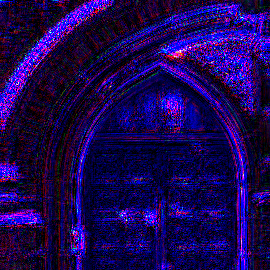

In [32]:
import PIL
PIL.Image.open("result.png")